In [2]:
# Import sys, then tell python where to find the nEXO-specific classes
# I'll assume you're in the sensitivity/work directory, as shown here by !pwd

import sys
!pwd
sys.path.append('../../../modules')

/g/g20/lenardo1/nEXO/sensitivity/work/SensitivityPaper2020_scripts/NonGaussianityStudy


In [45]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt
import os

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

cmap = plt.get_cmap('viridis')
fivecolors = cmap(np.linspace(0.,1.,7))

colordict = {'cb_a1_n2':fivecolors[4],'cb_a1p25_n5':fivecolors[3],'cb_a1p5_n5':fivecolors[2],'cb_a3_n5':fivecolors[1],'gaus':fivecolors[0]}


In [30]:
# Import the nEXO sensitivity classes

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

import importlib

importlib.reload(nEXOFitWorkspace)

<module 'nEXOFitWorkspace' from '../../../modules/nEXOFitWorkspace.py'>

In [31]:
# Define some useful functions

from scipy.special import erf

def CrystalBall( x, a, n, mu, sig ):
    A = ( n/np.abs(a) )**n * np.exp(-(a**2)/2.)
    B = n / np.abs(a) - np.abs(a)
    C = n / np.abs(a) * 1/(n-1) * np.exp(-(a**2)/2.)
    D = np.sqrt(np.pi/2.) * (1 + erf(np.abs(a)/np.sqrt(2)))
    N = 1./( sig*(C + D))
    
    mask = (x-mu)/sig > -a
    output = np.zeros(len(x))
    output[mask] = np.exp( -(x[mask]-mu)**2/(2 * sig**2) )
    output[np.invert(mask)] = A * (B - (x[np.invert(mask)]-mu)/sig)**(-n)
    
    return output

def Gaussian( x, A, mu, sig ):
    return A * np.exp( -(x-mu)**2/(2.*sig**2) )

# Different smearing distributions

We use a Crystal Ball function (https://en.wikipedia.org/wiki/Crystal_Ball_function) to add a low-energy, non-gaussian tail to the energy smearing funciton. This models the effect of incomplete charge collection, which has been observed in the charge waveform simulations. As our full waveform analysis is not yet developed, we try a few different crystal ball functions to model a range of different experimental possibilities. 

As our resolution ($\sigma$) is fixed by our expected 1% energy resolution at the Q-value, there are two free parameters in the CB function: `a` and `n`. We use:

|  a   |  n   |
|------|------|
| 1    |  2   |
| 1.25 |  5   |
| 1.5  |  5   |
|  3   |  5   |

These are plotted below with $\sigma = 1$ and $\mu = 0$, along with a standard normal distribution for comparison

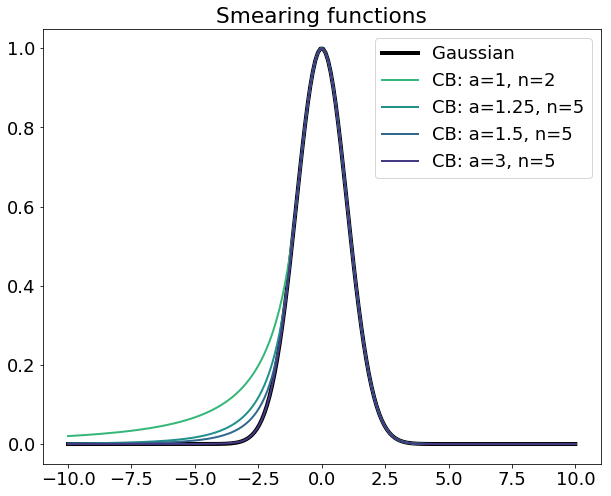

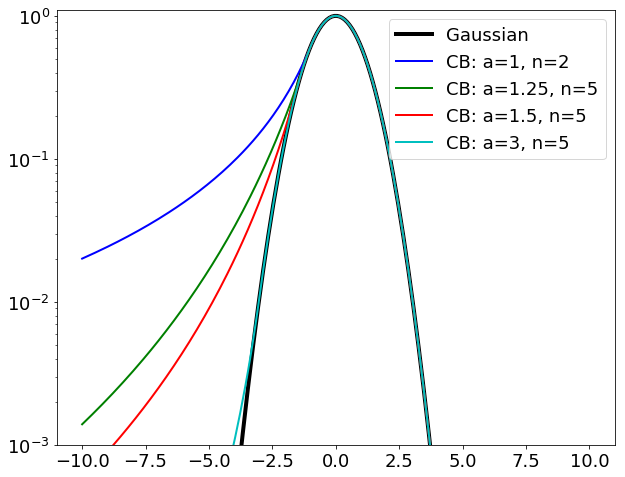

In [46]:
a_n_values = [ (1,2), (1.25, 5), (1.5,5), (3,5), (2.,0.5) ]
names = ['cb_a1_n2','cb_a1p25_n5','cb_a1p5_n5','cb_a3_n5']
x = np.linspace(-10.,10.,200)

plt.plot(x,Gaussian(x,1.,0.,1.),linewidth=4,color='k',label='Gaussian')

for i in range(4):

    pair = a_n_values[i]
    name = names[i]
    
    y = CrystalBall(x,pair[0],pair[1],0.,1.)
    if pair[1] > 1.:
        plt.plot(x,y,linewidth=2,label='CB: a={}, n={}'.format(pair[0],pair[1]),color=colordict[name])
    else:
        test=1 #plt.plot(x,y,linewidth=2,linestyle='--',label='CB: a={}, n={}'.format(pair[0],pair[1]))
    

#plt.xlabel('X')
plt.legend()
#plt.yscale('log')
plt.title('Smearing functions')

plt.savefig('plots/different_smearing_models_linear.png',dpi=150,bbox_inches='tight')




plt.figure(2)

plt.plot(x,Gaussian(x,1.,0.,1.),linewidth=4,color='k',label='Gaussian')

for pair in a_n_values:

    y = CrystalBall(x,pair[0],pair[1],0.,1.)
    if pair[1] > 1.:
        plt.plot(x,y,linewidth=2,label='CB: a={}, n={}'.format(pair[0],pair[1]))
    else:
        test=1 #plt.plot(x,y,linewidth=2,linestyle='--',label='CB: a={}, n={}'.format(pair[0],pair[1]))
    

#plt.xlabel('X')
plt.legend()
plt.yscale('log')
plt.ylim(0.001,1.1)

plt.savefig('plots/different_smearing_models_log.png',dpi=150,bbox_inches='tight')



# Computing the sensitivity for each smeared dataset

We apply the different smearing functions above to the true MC energy distributions to generate a different background model for each different function. We then compute the sensitivity as usual; we run an ensemble 1000 toy datasets for each different background model, and compute the 90% confidence limit for each. The median of the ensemble is then taken as the expected sensitivity. 

In [8]:
# Load in all the output files from the various sensitivity calculations, for each different smeared model
# Each different model was split into 25 files for the calculation, so this step just creates lists of the
# relevant file names.


outputdir = '/p/lustre1/lenardo1/sensitivity_output/May28_2020_nongaussianity_test/ThirdTry/'

output_files = os.listdir( outputdir )
h5_files = [filename for filename in output_files if filename.endswith('.h5')]

files_lists = dict()

files_lists['gaus'] = [outputdir+filename for filename in h5_files if 'gaus' in filename]
files_lists['cb_a1_n2'] = [outputdir+filename for filename in h5_files if 'cb_a1_n2' in filename]
files_lists['cb_a1p25_n5'] = [outputdir+filename for filename in h5_files if 'cb_a1p25_n5' in filename]
files_lists['cb_a1p5_n5'] = [outputdir+filename for filename in h5_files if 'cb_a1p5_n5' in filename]
files_lists['cb_a3_n5'] = [outputdir+filename for filename in h5_files if 'cb_a3_n5' in filename]

In [9]:
second_outputdir = '/p/lustre1/lenardo1/sensitivity_output/May28_2020_nongaussianity_test/FourthTry/'

output_files = os.listdir( second_outputdir )
h5_files = [filename for filename in output_files if filename.endswith('.h5')]


second_files_lists = dict()

second_files_lists['gaus'] = [second_outputdir+filename for filename in h5_files if 'gaus' in filename]
second_files_lists['cb_a1_n2'] = [second_outputdir+filename for filename in h5_files if 'cb_a1_n2' in filename]
second_files_lists['cb_a1p25_n5'] = [second_outputdir+filename for filename in h5_files if 'cb_a1p25_n5' in filename]
second_files_lists['cb_a1p5_n5'] = [second_outputdir+filename for filename in h5_files if 'cb_a1p5_n5' in filename]
second_files_lists['cb_a3_n5'] = [second_outputdir+filename for filename in h5_files if 'cb_a3_n5' in filename]

files_lists['gaus'].extend(second_files_lists['gaus'])
files_lists['cb_a1_n2'].extend(second_files_lists['cb_a1_n2'])
files_lists['cb_a1p25_n5'].extend(second_files_lists['cb_a1p25_n5'])
files_lists['cb_a1p5_n5'].extend(second_files_lists['cb_a1p5_n5'])
files_lists['cb_a3_n5'].extend(second_files_lists['cb_a3_n5'])

print(files_lists['gaus'])



['/p/lustre1/lenardo1/sensitivity_output/May28_2020_nongaussianity_test/ThirdTry/sens_output_file_90CL_gaus_011.h5', '/p/lustre1/lenardo1/sensitivity_output/May28_2020_nongaussianity_test/ThirdTry/sens_output_file_90CL_gaus_006.h5', '/p/lustre1/lenardo1/sensitivity_output/May28_2020_nongaussianity_test/ThirdTry/sens_output_file_90CL_gaus_007.h5', '/p/lustre1/lenardo1/sensitivity_output/May28_2020_nongaussianity_test/ThirdTry/sens_output_file_90CL_gaus_010.h5', '/p/lustre1/lenardo1/sensitivity_output/May28_2020_nongaussianity_test/ThirdTry/sens_output_file_90CL_gaus_012.h5', '/p/lustre1/lenardo1/sensitivity_output/May28_2020_nongaussianity_test/ThirdTry/sens_output_file_90CL_gaus_005.h5', '/p/lustre1/lenardo1/sensitivity_output/May28_2020_nongaussianity_test/ThirdTry/sens_output_file_90CL_gaus_004.h5', '/p/lustre1/lenardo1/sensitivity_output/May28_2020_nongaussianity_test/ThirdTry/sens_output_file_90CL_gaus_013.h5', '/p/lustre1/lenardo1/sensitivity_output/May28_2020_nongaussianity_test/

In [10]:
# Concatenate the pandas dataframes in each file into a single table of sensitivity output values, for each
# different model

df_dict = dict()

for model, files_list in files_lists.items():
    
    df_list = []
    print('Grabbing files for dataset {}'.format(model))
    
    for filename in files_list:
        df_list.append( pd.read_hdf( filename ) )
        
    print('Concatenating files...')
    full_df = pd.concat(df_list,ignore_index=True)
    
    df_dict[model] = full_df
    
    

Grabbing files for dataset gaus
Concatenating files...
Grabbing files for dataset cb_a1_n2
Concatenating files...
Grabbing files for dataset cb_a1p25_n5
Concatenating files...
Grabbing files for dataset cb_a1p5_n5
Concatenating files...
Grabbing files for dataset cb_a3_n5
Concatenating files...


In [11]:
hist_dict = dict()
medians_dict = dict()

for model, df in df_dict.items():
    
    fixed_fit_mask = []
    
    # This loop just checks to see if more than one of the fixed-fits failed for a specific toy dataset
    for index,row in df.iterrows():
        if len(row['fixed_fit_acc_covar']) - np.sum(row['fixed_fit_acc_covar']) < 2:
            fixed_fit_mask.append(True)
        else:
            fixed_fit_mask.append(False)
    
    
    good_fits_mask = (df['best_fit_covar'])&np.array(fixed_fit_mask)

    hist_dict[model] = hl.hist(df['90CL_crossing'].loc[good_fits_mask],bins=np.linspace(0.,50.,15))
    
    # Compute fraction of events with good best fit, and one or fewer failed fixed fits
    convergence_fraction = np.sum(good_fits_mask)/len(good_fits_mask)
    
    medians_dict[model] = np.median(df['90CL_crossing'].loc[good_fits_mask])
    
    print('Model: {:<10}\tMedian: {:>6.4}\t   \'Convergence\' rate: {:>6.4}'.format( model,\
                                      np.median(df['90CL_crossing'].loc[good_fits_mask]),\
                                      convergence_fraction))
    
    

Model: gaus      	Median:  11.61	   'Convergence' rate:  0.961
Model: cb_a1_n2  	Median:  14.96	   'Convergence' rate: 0.9177
Model: cb_a1p25_n5	Median:  12.51	   'Convergence' rate: 0.9477
Model: cb_a1p5_n5	Median:  12.06	   'Convergence' rate: 0.9487
Model: cb_a3_n5  	Median:  11.66	   'Convergence' rate: 0.9493


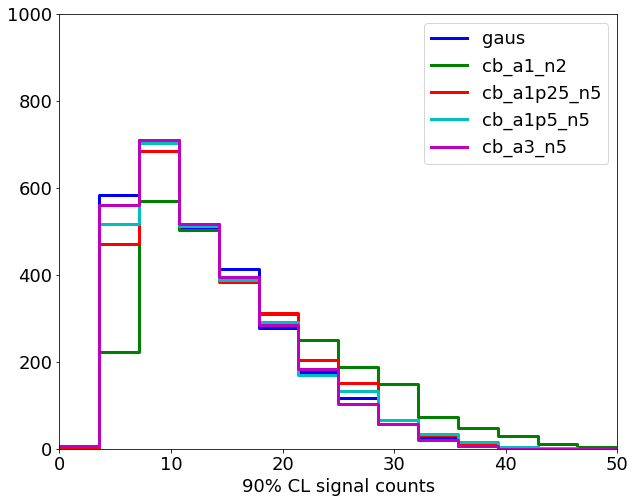

In [12]:
for dataset, hist in hist_dict.items():
    hl.plot1d(hist,label=dataset,linewidth=3)
    
plt.xlabel('90% CL signal counts')
plt.xlim(0.,50)
plt.ylim(0.,1000.)
plt.legend()


Gaussian integral: 167.0
cb_a1_n2 tail fraction: 0.2183
cb_a1p25_n5 tail fraction: 0.07134
cb_a1p5_n5 tail fraction: 0.03945
cb_a3_n5 tail fraction: 0.0004963
Slope of linfit: -1.021


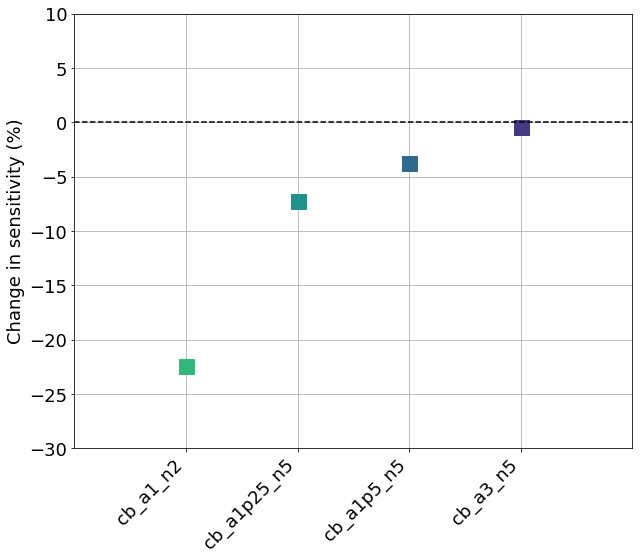

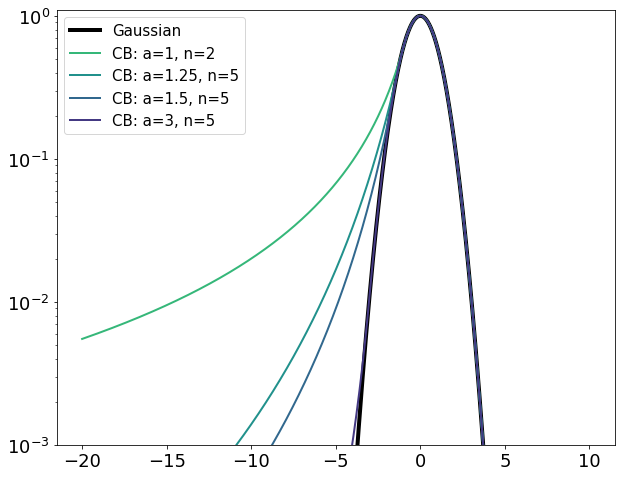

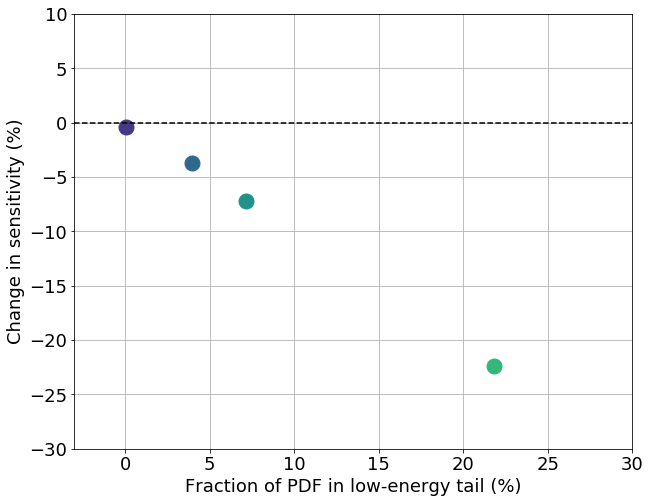

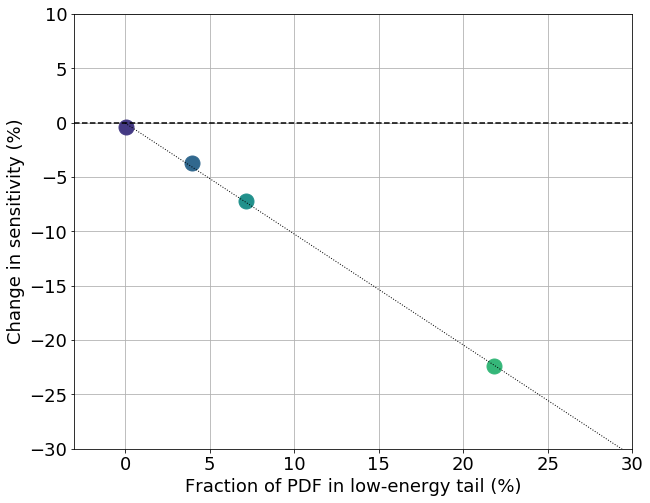

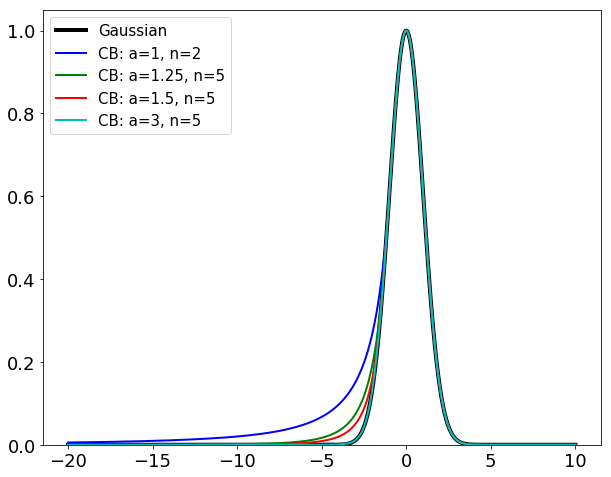

In [62]:
names_list = []

gaus_val = medians_dict['gaus']
plot_colors_dict = dict()

fraction_of_area_in_tail = dict()
fraction_of_area_in_tail_list = []

counter = 0

x = np.linspace(-20.,10.,2000)

for key, value in medians_dict.items():
    
    if key == 'gaus': continue
    
    names_list.append(key)
    thisplot, = plt.plot(counter,((1./value)/(1./gaus_val)-1.)*100,'s',markersize=15,color=colordict[key])
    plot_colors_dict[key] = thisplot.get_color()
    
    counter += 1
    
plt.xlim(-1.,4.)
plt.xticks([0,1,2,3],names_list,rotation=45,ha='right')
plt.ylim(-30,10)
plt.ylabel('Change in sensitivity (%)')
plt.plot(np.linspace(-1.,4.,100),np.zeros(100),'--k')
plt.grid()
plt.savefig('plots/sensitivity_values.png',dpi=150,bbox_inches='tight')

plt.figure(2)

plt.plot(x,Gaussian(x,1.,0.,1.),linewidth=4,color='k',label='Gaussian')
gaussian_integral = np.sum(Gaussian(x,1.,0.,1.))
print('Gaussian integral: {:4.4}'.format(gaussian_integral))

#for pair in a_n_values:
for i in range(4):

    pair = a_n_values[i]
    name = names[i]
    
    y = CrystalBall(x,pair[0],pair[1],0.,1.)
    
    
    fraction_of_area_in_tail[name] = (np.sum(y) - gaussian_integral)/np.sum(y)
    fraction_of_area_in_tail_list.append((np.sum(y) - gaussian_integral)/np.sum(y))
    print('{} tail fraction: {:4.4}'.format(name,fraction_of_area_in_tail[name]))
    
    if pair[1] > 1.:
        plt.plot(x,y,linewidth=2,label='CB: a={}, n={}'.format(pair[0],pair[1]),color=colordict[name])
    else:
        test=1 #plt.plot(x,y,linewidth=2,linestyle='--',label='CB: a={}, n={}'.format(pair[0],pair[1]))

#plt.xlabel('X')
plt.legend(fontsize=15)
plt.yscale('log')
plt.ylim(0.001,1.1)

plt.savefig('plots/smearing_functions_color_coded_with_sensitivity_values_log.png',dpi=150,bbox_inches='tight')

        
plt.figure(5)
sens_list = []
for key, value in medians_dict.items():
    
    if key == 'gaus': continue
    
    names_list.append(key)
    thisplot, = plt.plot(fraction_of_area_in_tail[key]*100,\
                         ((1./value)/(1./gaus_val)-1.)*100,\
                         'o',markersize=15,color=colordict[key])
    plot_colors_dict[key] = thisplot.get_color()
    sens_list.append(((1./value)/(1./gaus_val)-1.)*100)
    
    counter += 1
    
plt.ylim(-30,10)
plt.ylabel('Change in sensitivity (%)')
plt.xlabel('Fraction of PDF in low-energy tail (%)')
plt.xlim(-3.,30.)
plt.plot(np.linspace(-3.,30.,100),np.zeros(100),'--k')
plt.grid()
plt.savefig('plots/sensitivity_values_tail_fraction.png',dpi=150,bbox_inches='tight')


plt.figure(6)
for key, value in medians_dict.items():
    
    if key == 'gaus': continue
    
    names_list.append(key)
    thisplot, = plt.plot(fraction_of_area_in_tail[key]*100,\
                         ((1./value)/(1./gaus_val)-1.)*100,\
                         'o',markersize=15,color=colordict[key])
    plot_colors_dict[key] = thisplot.get_color()
    
    counter += 1
    
plt.ylim(-30,10)
plt.ylabel('Change in sensitivity (%)')
plt.xlabel('Fraction of PDF in low-energy tail (%)')
plt.xlim(-3.,30.)
plt.plot(np.linspace(-3.,30.,100),np.zeros(100),'--k')
p = np.polyfit(np.array(fraction_of_area_in_tail_list)*100,sens_list,1)
xfit = np.linspace(0.,30.,100)
yfit = p[0]*xfit + p[1]
print('Slope of linfit: {:4.4}'.format(p[0]))
plt.plot(xfit,yfit,':k',linewidth=1)
plt.grid()
plt.savefig('plots/sensitivity_values_tail_fraction_linfit.png',dpi=150,bbox_inches='tight')


plt.figure(3)

plt.plot(x,Gaussian(x,1.,0.,1.),linewidth=4,color='k',label='Gaussian')

for pair in a_n_values:

    y = CrystalBall(x,pair[0],pair[1],0.,1.)
    if pair[1] > 1.:
        plt.plot(x,y,linewidth=2,label='CB: a={}, n={}'.format(pair[0],pair[1]))
    else:
        test=1 #plt.plot(x,y,linewidth=2,linestyle='--',label='CB: a={}, n={}'.format(pair[0],pair[1]))
    

#plt.xlabel('X')
plt.legend(fontsize=15)
#plt.yscale('log')
plt.ylim(0.0,1.05)

plt.savefig('plots/smearing_functions_color_coded_with_sensitivity_values_linear.png',dpi=150,bbox_inches='tight')



# How many events in the ROI?

The ROI is defined as:

- Single-site events
- Within the FWHM of the Q-value (2457.83 keV)
- Inside the inner 2 tons (>120 mm standoff, in Baseline 2017 model)

We would like to know how many background events are in the ROI.

The functions to look at this are in the nEXOFitWorkspace and nEXOFitModel classes.

In [17]:
# First, let's load all the different models into their own workspaces and likelihood objects.

workspaces_dict = dict()
likelihoods_dict = dict()

tables_dir = '../../../tables/NonGaussianityStudy/'
tables_list = os.listdir(tables_dir)

for thismodel, df in df_dict.items():
    
    table_file = [table for table in tables_list if 'nongaussian_'+thismodel in table] [0]
    print(table_file)
    
    
    workspaces_dict[thismodel] = nEXOFitWorkspace.nEXOFitWorkspace('../../config/TUTORIAL_config.yaml')
    workspaces_dict[thismodel].LoadComponentsTableFromFile(tables_dir + table_file)
    workspaces_dict[thismodel].SetHandlingOfRadioassayData(fluctuate=False)
    workspaces_dict[thismodel].CreateGroupedPDFs()
    
    likelihoods_dict[thismodel] = nEXOFitLikelihood.nEXOFitLikelihood()
    likelihoods_dict[thismodel].AddPDFDataframeToModel( workspaces_dict[thismodel].df_group_pdfs, \
                                                       workspaces_dict[thismodel].histogram_axis_names )
    
    # Set the number of BB0n events to 0, so the model contains only background.
    initial_values = likelihoods_dict[thismodel].GetVariableValues()
    initial_values[ likelihoods_dict[thismodel].GetVariableIndex('Bb0n') ] = 0.
    likelihoods_dict[thismodel].model.UpdateVariables( initial_values )
    likelihoods_dict[thismodel].model.GenerateModelDistribution()

    


ComponentsTable_D-005_v25_2020-01-21_nongaussian_gaus.h5

Loading input data froma previously-generated components table....

Loaded dataframe with 130 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	MC ID
	Histogram
	HistogramAxisNames
	Total Mass or Area
	Halflife
	SpecActiv
	SpecActivErr
	RawActiv
	RawActivErr
	Activity ID
	Expected Counts
	Expected Counts Err
	Expected Counts UL
	TotalHitEff_N
	TotalHitEff_K
	Group

Fit variables:
	['SS/MS', 'Energy (keV)', 'Standoff (mm)']

Creating grouped PDFs....
	Group:                              	Expected Counts:
	Far                                 	      4554.1834
	Vessel_U238                         	     19053.0261
	Vessel_Th232                        	       699.3680
	Internals_U238                      	     22538.6557
	Internals_Th232                     	      8566.3828
	FullTPC_Co60                        	       216.1884
	FullTPC_K40                         	  32572615.7480
	Rn222          

In [18]:
# Next, let's see what the axes are called. It will be the same for all 
# the different models, so let's just look at the 'gaus' model

print(workspaces_dict['gaus'].histogram_axis_names)


['SS/MS', 'Energy (keV)', 'Standoff (mm)']


In [19]:
# Now, we can define the ROI as a dict in these variables:
roi_dict = { 'SS/MS': [0.,1.], 'Energy (keV)': [ 2428.89, 2486.77 ], 'Standoff (mm)': [ 120., 650. ] }




In [20]:
for thismodel, workspace in workspaces_dict.items():
    print('\nModel: {}'.format(thismodel))
    workspaces_dict[thismodel].DefineROI( roi_dict )

    # The following will also tell you where the ROI boundaries are, given
    # the binning of the PDFs

    # workspace.PrintROIEdges()



Model: gaus
SS/MS:
	Input ROI boundaries:       0.0,      1.0
	Actual ROI boundaries:      0.0,      1.0
Energy (keV):
	Input ROI boundaries:    2428.9,   2486.8
	Actual ROI boundaries:   2430.0,   2490.0
Standoff (mm):
	Input ROI boundaries:     120.0,    650.0
	Actual ROI boundaries:    110.0,    650.0

Model: cb_a1_n2
SS/MS:
	Input ROI boundaries:       0.0,      1.0
	Actual ROI boundaries:      0.0,      1.0
Energy (keV):
	Input ROI boundaries:    2428.9,   2486.8
	Actual ROI boundaries:   2430.0,   2490.0
Standoff (mm):
	Input ROI boundaries:     120.0,    650.0
	Actual ROI boundaries:    110.0,    650.0

Model: cb_a1p25_n5
SS/MS:
	Input ROI boundaries:       0.0,      1.0
	Actual ROI boundaries:      0.0,      1.0
Energy (keV):
	Input ROI boundaries:    2428.9,   2486.8
	Actual ROI boundaries:   2430.0,   2490.0
Standoff (mm):
	Input ROI boundaries:     120.0,    650.0
	Actual ROI boundaries:    110.0,    650.0

Model: cb_a1p5_n5
SS/MS:
	Input ROI boundaries:       0.0,      1.0

Background in ROI for cb_a1_n2:        10.7
Background in ROI for cb_a1p25_n5:    10.51
Background in ROI for cb_a1p5_n5:     10.57
Background in ROI for cb_a3_n5:       10.67


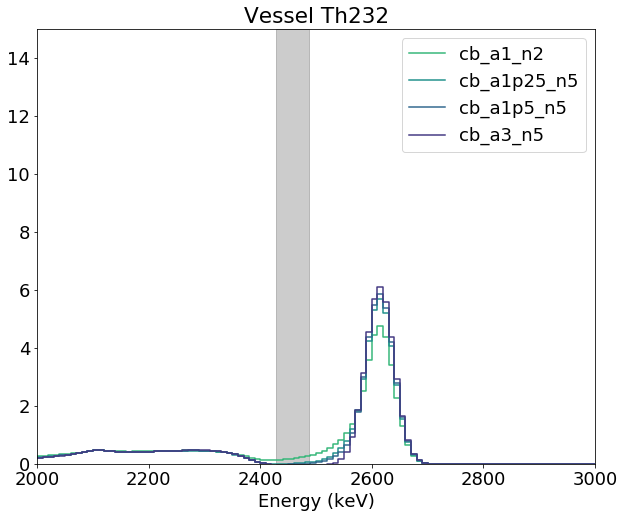

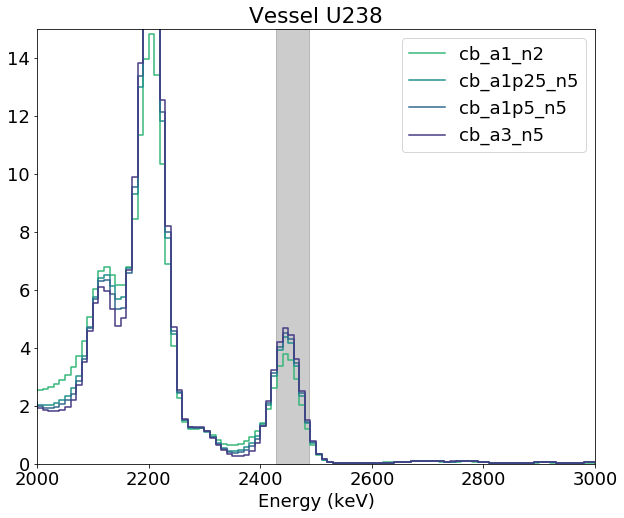

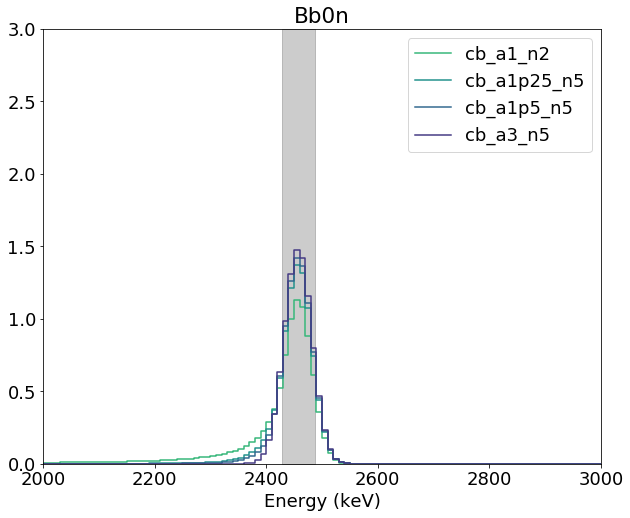

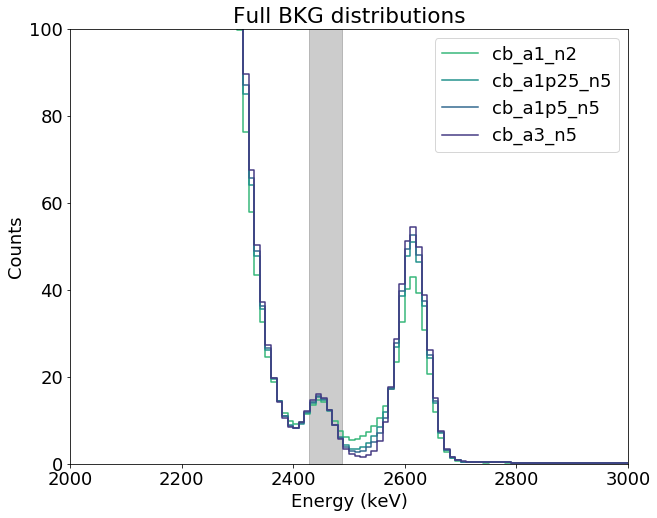

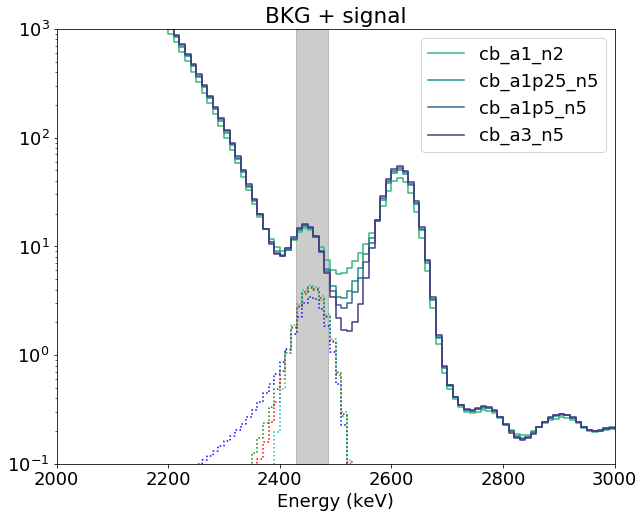

In [48]:
counter = 0

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

for thismodel, workspace in workspaces_dict.items():
    
    #print(thismodel)
    if thismodel == 'gaus':
        continue
    
    bkg_counts = likelihoods_dict[thismodel].model.GetIntegralInBinRange( workspace.GetROIBinIndices() )
    print('Background in ROI for {:<15} {:>5.4}'.format( thismodel+':', bkg_counts) )
    
    
    #plt.figure(counter); counter += 1
    #likelihoods_dict[thismodel].PlotModelDistributions()
    
    plt.figure(1)
    idx = likelihoods_dict[thismodel].model.GetVariableIndexByName('Vessel_Th232')
    weight = likelihoods_dict[thismodel].model.variable_list[idx]['Value']
    pdf = likelihoods_dict[thismodel].model.pdfs[idx]
    hl.plot1d( (weight * pdf)[0:1].project([1]), label=thismodel, color=colordict[thismodel] )
    
    plt.figure(2)
    idx = likelihoods_dict[thismodel].model.GetVariableIndexByName('Vessel_U238')
    weight = likelihoods_dict[thismodel].model.variable_list[idx]['Value']
    pdf = likelihoods_dict[thismodel].model.pdfs[idx]
    hl.plot1d( (weight * pdf)[0:1].project([1]), label=thismodel, color=colordict[thismodel] )

    plt.figure(3)
    idx = likelihoods_dict[thismodel].model.GetVariableIndexByName('Bb0n')
    weight = 10. #likelihoods_dict[thismodel].model.variable_list[idx]['Value']
    pdf = likelihoods_dict[thismodel].model.pdfs[idx]
    hl.plot1d( (weight * pdf)[0:1].project([1]), label=thismodel, color=colordict[thismodel] )
    
    plt.figure(4)
    hl.plot1d( likelihoods_dict[thismodel].model.full_distribution[0:1].project([1]), label=thismodel, color=colordict[thismodel] )
    
    plt.figure(5)
    init_plot, = plt.plot([1.,1.],[1.,1.])
    hl.plot1d( likelihoods_dict[thismodel].model.full_distribution[0:1].project([1]), color=colordict[thismodel], label=thismodel )
    idx = likelihoods_dict[thismodel].model.GetVariableIndexByName('Bb0n')
    weight = 30. #likelihoods_dict[thismodel].model.variable_list[idx]['Value']
    pdf = likelihoods_dict[thismodel].model.pdfs[idx]
    hl.plot1d( (weight * pdf)[0:1].project([1]),  linestyle=':', color=init_plot.get_color() )
    
    

plt.figure(1)
plt.legend()
plt.xlabel('Energy (keV)')
plt.title('Vessel Th232')
plt.ylim(0.,15.)
plt.xlim(2000.,3000.)
x1_patch = np.ones(100) * roi_dict['Energy (keV)'][0]
x2_patch = np.ones(100) * roi_dict['Energy (keV)'][1]
y1_patch = np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],100)
plt.fill_betweenx(y1_patch,x1_patch,x2_patch,color=(0.,0.,0.),alpha=0.2)
plt.savefig('plots/vessel_th232_ss_pdfs.png',dpi=150,bbox_inches='tight')

plt.figure(2)
plt.legend()
plt.xlabel('Energy (keV)')
plt.title('Vessel U238')
plt.ylim(0.,15.)
plt.xlim(2000.,3000.)
x1_patch = np.ones(100) * roi_dict['Energy (keV)'][0]
x2_patch = np.ones(100) * roi_dict['Energy (keV)'][1]
y1_patch = np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],100)
plt.fill_betweenx(y1_patch,x1_patch,x2_patch,color=(0.,0.,0.),alpha=0.2)
plt.savefig('plots/vessel_u238_ss_pdfs.png',dpi=150,bbox_inches='tight')

plt.figure(3)
plt.legend()
plt.xlabel('Energy (keV)')
plt.title('Bb0n')
plt.ylim(0.,3.)
plt.xlim(2000.,3000.)
x1_patch = np.ones(100) * roi_dict['Energy (keV)'][0]
x2_patch = np.ones(100) * roi_dict['Energy (keV)'][1]
y1_patch = np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],100)
plt.fill_betweenx(y1_patch,x1_patch,x2_patch,color=(0.,0.,0.),alpha=0.2)
plt.savefig('plots/signal_ss_pdfs_linear.png',dpi=150,bbox_inches='tight')

plt.figure(4)
plt.legend()
plt.xlabel('Energy (keV)')
plt.title('Full BKG distributions')
#plt.ylim(0.1,1000.)
#plt.yscale('linear')
plt.ylim(0.,100.)
plt.xlim(2000.,3000.)
x1_patch = np.ones(100) * roi_dict['Energy (keV)'][0]
x2_patch = np.ones(100) * roi_dict['Energy (keV)'][1]
y1_patch = np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],100)
plt.fill_betweenx(y1_patch,x1_patch,x2_patch,color=(0.,0.,0.),alpha=0.2)
plt.ylabel('Counts')
plt.savefig('plots/full_bkg_ss_pdfs_linear.png',dpi=150,bbox_inches='tight')


plt.figure(5)
plt.legend()
plt.xlabel('Energy (keV)')
plt.title('BKG + signal')
plt.ylim(0.1,1000.)
plt.yscale('log')
plt.xlim(2000.,3000.)
x1_patch = np.ones(100) * roi_dict['Energy (keV)'][0]
x2_patch = np.ones(100) * roi_dict['Energy (keV)'][1]
y1_patch = np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],100)
plt.fill_betweenx(y1_patch,x1_patch,x2_patch,color=(0.,0.,0.),alpha=0.2)
plt.savefig('plots/full_bkg_and_signal_pdfs_log.png',dpi=150,bbox_inches='tight')
    
    


In [22]:
print('Contribution from each component in ROI:')

for component in likelihoods_dict['gaus'].model.variable_list:
    num_counts_in_roi = likelihoods_dict['gaus'].model.GetComponentIntegralInBinRange( \
                                            component['Name'], workspace.GetROIBinIndices() )
    print('{:<20}\t{:>10.4}'.format( component['Name']+':', num_counts_in_roi ) )
    
    

Contribution from each component in ROI:
Num_Far:            	    0.6554
Num_Vessel_U238:    	     3.392
Num_Vessel_Th232:   	   -0.1058
Num_Internals_U238: 	     3.461
Num_Internals_Th232:	    0.4597
Num_FullTPC_Co60:   	       0.0
Num_FullTPC_K40:    	       0.0
Num_Rn222:          	     2.125
Num_FullLXeBb2n:    	    0.2278
Num_FullLXeBb0n:    	       0.0
Num_Xe137:          	    0.4549
